In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PySpark").getOrCreate()
spark

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [3]:
def printdf(df, l=5):
    return df.limit(l).toPandas()

def nullcount(df):
    return {col: df.filter(df[col].isNull()).count() for col in df.columns}

def shape(df):
    # df.toPandas().shape
    print((df.count(), len(df.columns)))

In [4]:
data = spark.read.csv("OnlineRetail.csv", 
                      inferSchema=True, 
                      header=True)
print('Dataframe dimensions:', (data.count(), len(data.columns)))
printdf(data)

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


# EDA

In [5]:
# data.describe().show()
# data.printSchema()

In [6]:
# Check the shape (number of columns and rows) in the dataset

# data.toPandas().shape
data.toPandas().describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
nullcount(data)

{'InvoiceNo': 0,
 'StockCode': 0,
 'Description': 1454,
 'Quantity': 0,
 'InvoiceDate': 0,
 'UnitPrice': 0,
 'CustomerID': 135080,
 'Country': 0}

In [8]:
# Customer distribution by country

rtl_data = data["Country", "CustomerID"].distinct()\
    .groupBy("Country")\
    .agg(F.count("CustomerID").alias("Count"))\
    .withColumn('Total', F.sum('Count').over(Window.partitionBy()))\
    .withColumn('%', (F.col('Count')/F.col('Total'))*100)\
    .sort("Count", ascending=False)

printdf(rtl_data)

,Country,Count,Total,%
0,United Kingdom,3950,4380,90.182648
1,Germany,95,4380,2.168950
2,France,87,4380,1.986301
3,Spain,31,4380,0.707763
4,Belgium,25,4380,0.570776


**Looks like 90% of the customers are from UK**  
**So, from now on we'll consider only UK's customers**

In [9]:
# Consider only customers from UK
rtl_data = data.filter(F.col("Country") == "United Kingdom")

# Filter out null customer ids
rtl_data = rtl_data.filter(F.col("CustomerID").isNotNull())

rtl_data.toPandas().shape

printdf(rtl_data)
# rtl_data.toPandas().describe()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [10]:
# Other approach to check null counts
nullcount(rtl_data)

{'InvoiceNo': 0,
 'StockCode': 0,
 'Description': 0,
 'Quantity': 0,
 'InvoiceDate': 0,
 'UnitPrice': 0,
 'CustomerID': 0,
 'Country': 0}

In [11]:
# Explore the schema of the dataframe
# rtl_data.printSchema()

In [12]:
# See basic stats of numeric columns
rtl_data.toPandas().describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [13]:
# Remove negative Quantities
rtl_data = rtl_data.filter(F.col("Quantity") > 0)

# Introduce Total Amount column
rtl_data = rtl_data.withColumn("TotalAmount", F.col("Quantity") * F.col("UnitPrice"))

# Reformat invoice date to yyyy-MM-dd
rtl_data = rtl_data.withColumn("InvoiceDate", 
                               F.to_date(F.col("InvoiceDate"), 'MM/dd/yyyy'))
# rtl_data = rtl_data.withColumn("InvoiceDate", F.from_unixtime(F.unix_timestamp(F.col("InvoiceDate"), 'MM/dd/yyyy')))

printdf(rtl_data)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,20.34


In [14]:
# Max and Min Date

df = rtl_data.toPandas()

print(df.InvoiceDate.min())
print(df.InvoiceDate.max())

2010-12-01
2011-12-09


In [15]:
# rtl_data.printSchema()

In [16]:
# Check null count one more time
# nullcount(rtl_data)

# RFM Modeling

In [17]:
rtl_data.select(F.max('InvoiceDate')).collect()

[Row(max(InvoiceDate)=datetime.date(2011, 12, 9))]

In [18]:
# Recency = Latest Date - Last Inovice Data 
# Frequency = count of invoice no. of transaction(s)
# Monetary = Sum of Total amount for each customer

import datetime as dt

# Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate the number of days from recent purchase
latest_date = F.to_date(F.lit("2011/12/10"), 'yyyy/MM/dd')

# Create RFM Modelling scores for each customer
rfm_scores = rtl_data.groupBy("CustomerID")\
    .agg((F.datediff(latest_date, F.max(F.col("InvoiceDate")))).alias("Recency"),
         F.count(F.col("InvoiceNo")).alias("Frequency"),
         F.sum(F.col("TotalAmount")).alias("Monetary"))

printdf(rfm_scores)

,CustomerID,Recency,Frequency,Monetary
0,17420,51,30,598.83
1,16503,107,84,1431.93
2,15727,17,302,5178.96
3,17389,1,213,31833.68
4,15447,331,9,155.17


In [19]:
rfm_scores.toPandas().describe()

,CustomerID,Recency,Frequency,Monetary
count,3921.000000,3921.000000,3921.000000,3921.000000
mean,15561.471563,92.722265,90.371079,1863.910113
std,1576.823683,99.528532,217.796155,7481.922217
min,12346.000000,1.000000,1.000000,0.000000
25%,14208.000000,18.000000,17.000000,300.040000
50%,15569.000000,51.000000,41.000000,651.820000
75%,16913.000000,143.000000,99.000000,1575.890000
max,18287.000000,374.000000,7847.000000,259657.300000


### Explore the RFM Scores using SNS

In [20]:
# df_rfm_scores = rfm_scores.sample(False, 0.9, 41).toPandas()

In [21]:
# type(df_rfm_scores)

In [22]:
rfm_scores_df = rfm_scores.toPandas()

<AxesSubplot:xlabel='Monetary', ylabel='Count'>

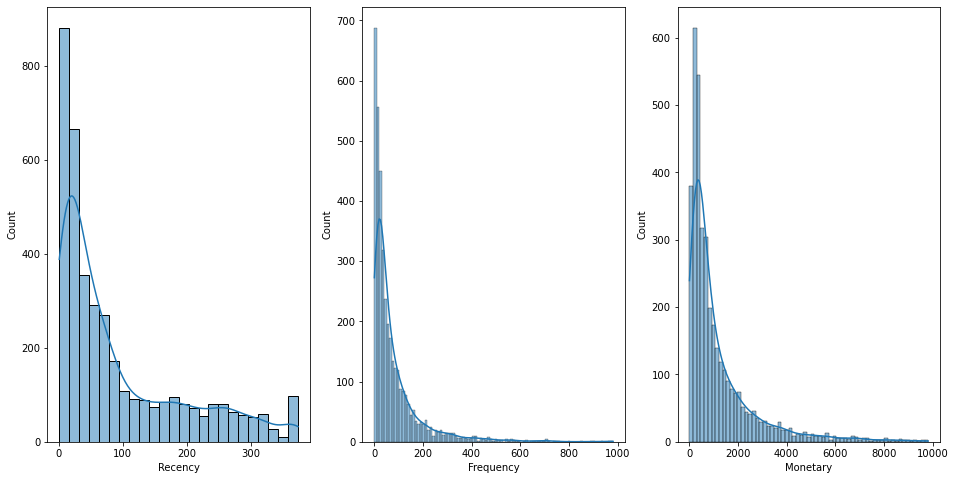

In [23]:
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(rfm_scores_df['Recency'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(rfm_scores_df.query('Frequency < 1000')['Frequency'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(rfm_scores_df.query('Monetary < 10000')['Monetary'], kde=True, ax=ax[2])

### Calculate RFM Scores

In [24]:
# We are going to divide our customer base into 3 segments: 
#    1st segment: top 20%
#    2nd segment: 20% - 60%
#    3rd segment: bottom 40%

# Understand and calculate different quantiles

# rfm_scores.toPandas()["Recency"].describe()

segments = [0.33, 0.66]

quantiles = rfm_scores.approxQuantile(
    ["Recency", "Frequency", "Monetary"], 
    segments, 
    0)
quantiles

[[25.0, 89.0], [23.0, 71.0], [370.47999999999996, 1106.53]]

In [25]:
# salary = spark.read.csv("employee_quartile.csv", inferSchema=True, header=True)
# salary.approxQuantile("salary", [0.25, 0.5, 0.75], 0)

In [26]:
# Calculate R,F,M vavlues considering quantiles

rfm_scores = (rfm_scores
    .withColumn(
        "R_Score",
        F.when(F.col("Recency") < quantiles[0][0], F.lit(1))
         .when(F.col("Recency") < quantiles[0][1], F.lit(2))
         .otherwise(F.lit(3)))
    .withColumn(
        "F_Score",
        F.when(F.col("Frequency") < quantiles[1][0], F.lit(3))
         .when(F.col("Frequency") < quantiles[1][1], F.lit(2))
         .otherwise(F.lit(1)))
    .withColumn(
        "M_Score",
        F.when(F.col("Monetary") < quantiles[2][0], F.lit(3))
         .when(F.col("Monetary") < quantiles[2][1], F.lit(2))
         .otherwise(F.lit(1))))

# printdf(rfm_scores.filter(F.col("CustomerID").isin([12346,12747,12748,12749,12820])))
# printdf(rfm_scores)

# rfm_scores.describe().show()

In [27]:
# Aggregate RFM scores

rfm_agg_scores = (rfm_scores
    .withColumn("RFM_Score", 
                F.col("R_Score") + 
                F.col("F_Score") + 
                F.col("M_Score"))
    .withColumn("RFM_ScoreGroup", 
                F.concat(
                    F.col("R_Score").cast(StringType()), 
                    F.col("F_Score").cast(StringType()), 
                    F.col("M_Score").cast(StringType())))
)


printdf(rfm_agg_scores)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_ScoreGroup
0,17420,51,30,598.83,2,2,2,6,222
1,16503,107,84,1431.93,3,1,1,5,311
2,15727,17,302,5178.96,1,1,1,3,111
3,17389,1,213,31833.68,1,1,1,3,111
4,15447,331,9,155.17,3,3,3,9,333


In [28]:
df_rfm_agg_scores = rfm_agg_scores.toPandas()
df_rfm_agg_scores.shape

(3921, 9)

<AxesSubplot:xlabel='RFM_ScoreGroup', ylabel='count'>

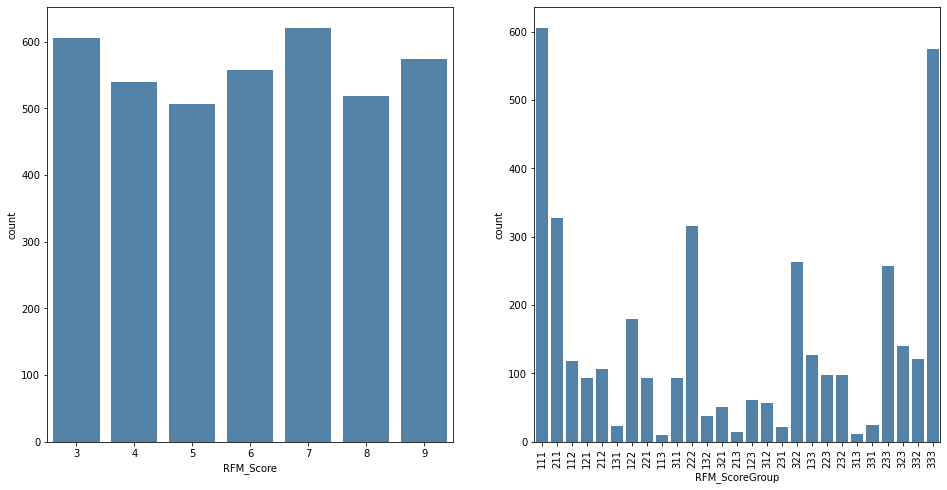

In [29]:
# Inspect RFM

df_rfm_agg_scores = df_rfm_agg_scores.sort_values(["RFM_Score"])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plt.xticks(rotation=90)
# sns.histplot(df_rfm_agg_scores["RFMScore"], kde=True, bins=10, ax=ax[0])
sns.countplot(x="RFM_Score", data=df_rfm_agg_scores, 
              color='steelblue', ax=ax[0])
sns.countplot(x="RFM_ScoreGroup", data=df_rfm_agg_scores, 
              color='steelblue', ax=ax[1])
# sns.histplot(df_rfm_agg_scores["RFMScoreGroup"], color='steelblue', ax=ax[2])

In [30]:
quantiles = rfm_agg_scores.approxQuantile("RFM_Score", segments, 0)
quantiles

[5.0, 7.0]

In [31]:
# Assign loyalty level to each customer

loyalty_level = ['Platinum', 'Gold', 'Silver']

rfm_loyalty = (rfm_agg_scores
    .withColumn(
        "Loyalty",
        F.when((F.col("RFM_Score") <= quantiles[0]), F.lit(loyalty_level[0]))
         .when((F.col("RFM_Score") <= quantiles[1]), F.lit(loyalty_level[1]))
         .otherwise(F.lit(loyalty_level[2]))))


In [32]:
# printdf(rfm_loyalty.filter(F.col("CustomerID").isin([12346,12747,12748,12749,12820])))
# printdf(rfm_loyalty.filter(F.col("RFM_ScoreGroup") == "111"), 10)
printdf(rfm_loyalty)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_ScoreGroup,Loyalty
0,17420,51,30,598.83,2,2,2,6,222,Gold
1,16503,107,84,1431.93,3,1,1,5,311,Platinum
2,15727,17,302,5178.96,1,1,1,3,111,Platinum
3,17389,1,213,31833.68,1,1,1,3,111,Platinum
4,15447,331,9,155.17,3,3,3,9,333,Silver


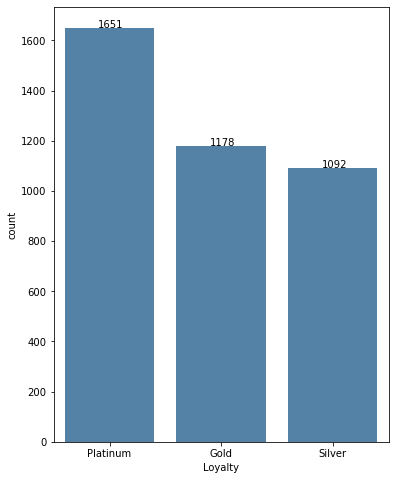

In [33]:
df_rfm_loyalty = rfm_loyalty.toPandas()
df_rfm_loyalty = df_rfm_loyalty.sort_values(["RFM_Score"])

fig, ax = plt.subplots(1, 1, figsize=(6, 8))

# sns.histplot(df_rfm_loyalty["Loyalty"], color='steelblue', shrink=.8)
sns.countplot(x="Loyalty", data=df_rfm_loyalty, color='steelblue')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))

In [34]:
# rfm_loyalty.write.format("csv").save('retail_loyalty_rfm_spark.csv')
df_rfm_loyalty.to_csv('retail_loyalty_rfm.csv', index=False)

# Visualize

In [35]:
# Restricting the dataset (Monetary < 5000 & Frequency < 500) to optimize the chart

df_rfm_loyalty = (rfm_loyalty
                  .filter(F.col("Monetary") < 5000)
                  .filter(F.col("Frequency") < 500)
#                   .filter(F.col("Loyalty") == "Platinum")
).toPandas()

<AxesSubplot:xlabel='Monetary', ylabel='Frequency'>

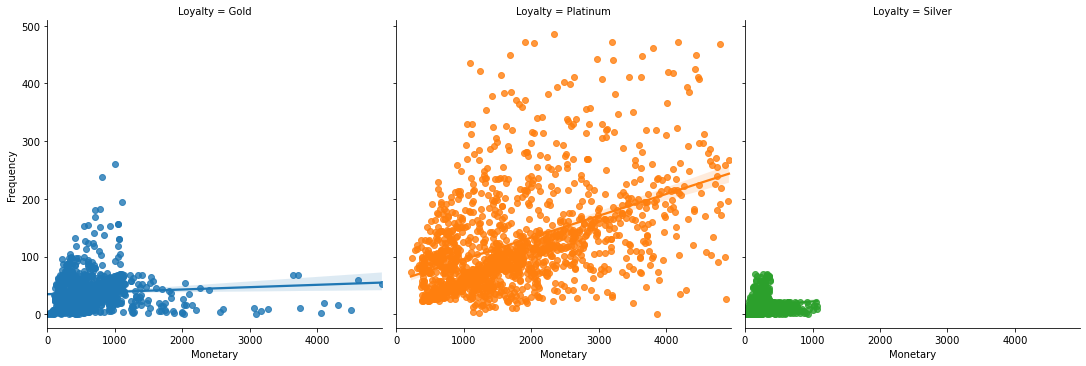

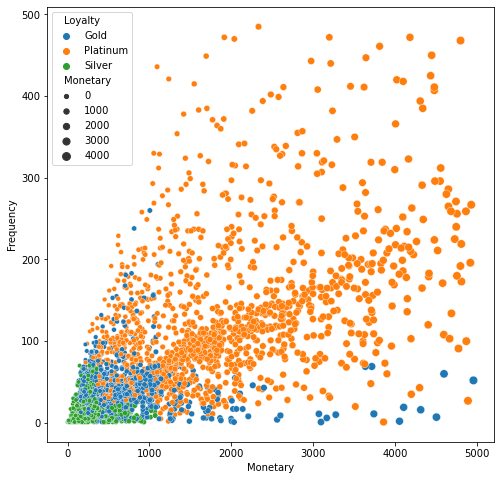

In [36]:
# Monetary vs Frequency for each segment
sns.lmplot(x='Monetary', y='Frequency', data=df_rfm_loyalty, col='Loyalty', hue='Loyalty', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Monetary', y='Frequency', data=df_rfm_loyalty, hue='Loyalty', size='Monetary')

<AxesSubplot:xlabel='Recency', ylabel='Monetary'>

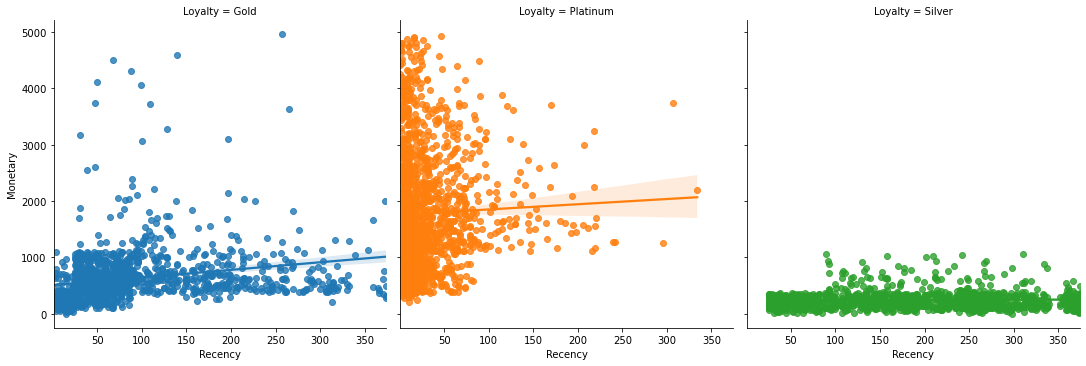

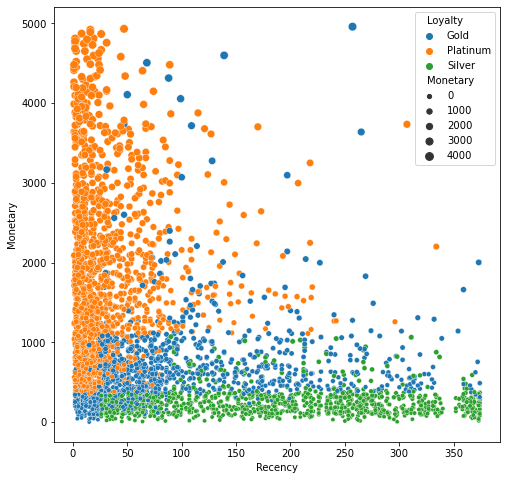

In [37]:
# Monetary vs Recency for each segment
sns.lmplot(x='Recency', y='Monetary', data=df_rfm_loyalty, col='Loyalty', hue='Loyalty', fit_reg=True)

# Monetary vs Recency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Monetary', data=df_rfm_loyalty, hue='Loyalty', size='Monetary')

<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

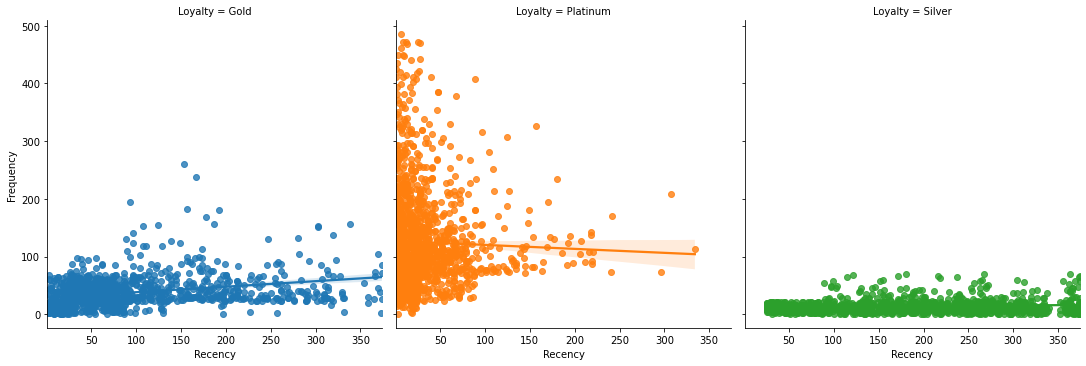

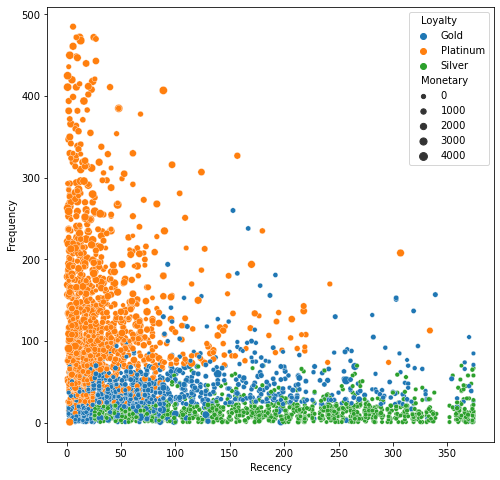

In [38]:
# Frequency vs Recency for each segment
sns.lmplot(x='Recency', y='Frequency', data=df_rfm_loyalty, col='Loyalty', hue='Loyalty', fit_reg=True)

# Monetary vs Recency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=df_rfm_loyalty, hue='Loyalty', size='Monetary')

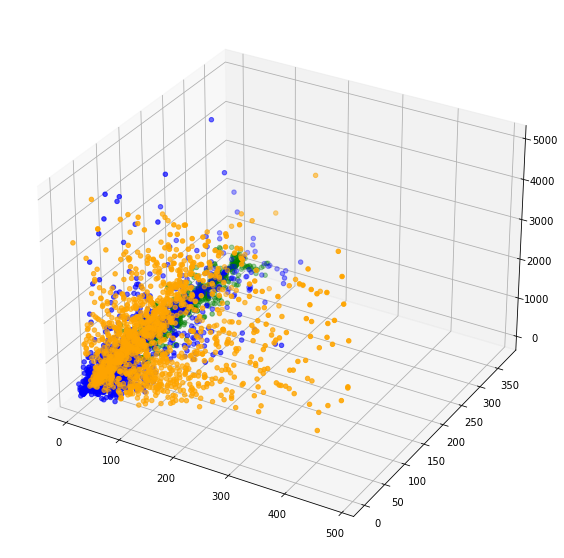

In [39]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

colors = {'Platinum':'orange', 'Gold':'blue', 'Silver':'green'}

ax.scatter(xs=df_rfm_loyalty.Frequency, 
           ys=df_rfm_loyalty.Recency, 
           zs=df_rfm_loyalty.Monetary, 
           c=[colors[x] for x in df_rfm_loyalty.Loyalty])